# Basics

Importing the datasets

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c covid-segmentation
!unzip \*.zip && rm *.zip

  0% 0.00/563k [00:00<?, ?B/s]
100% 563k/563k [00:00<00:00, 37.4MB/s]
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 93.1MB/s]
 36% 5.00M/13.9M [00:00<00:00, 14.4MB/s]
100% 13.9M/13.9M [00:00<00:00, 34.4MB/s]
 93% 295M/316M [00:07<00:00, 27.3MB/s]
100% 316M/316M [00:07<00:00, 43.5MB/s]
 96% 145M/150M [00:02<00:00, 42.7MB/s]
100% 150M/150M [00:03<00:00, 52.1MB/s]
Archive:  test_images_medseg.npy.zip
  inflating: test_images_medseg.npy  

Archive:  images_radiopedia.npy.zip
  inflating: images_radiopedia.npy   

Archive:  masks_radiopedia.npy.zip
  inflating: masks_radiopedia.npy    

Archive:  masks_medseg.npy.zip
  inflating: masks_medseg.npy        

Archive:  images_medseg.npy.zip
  inflating: images_medseg.npy       

5 archives were successfully processed.


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

import segmentation_models as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-q8ayac07
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-q8ayac07
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=aed56cd99fe48f66a1df468a75f82fcb9863852f70a52ce14fcf1f818735b836
  Stored in directory: /tmp/pip-ephem-wheel-cache-yepom9h4/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 310, done.
remote: Total 310 (delta 0), reused 0 (delta 0), pack-reused 310
Receiving objects: 100% (310/310), 131.62 KiB | 4.54 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Segmentation Models: using `keras` framework.


In [ ]:
prefix = '/content'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

Function for viewing images and their corresponding masks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

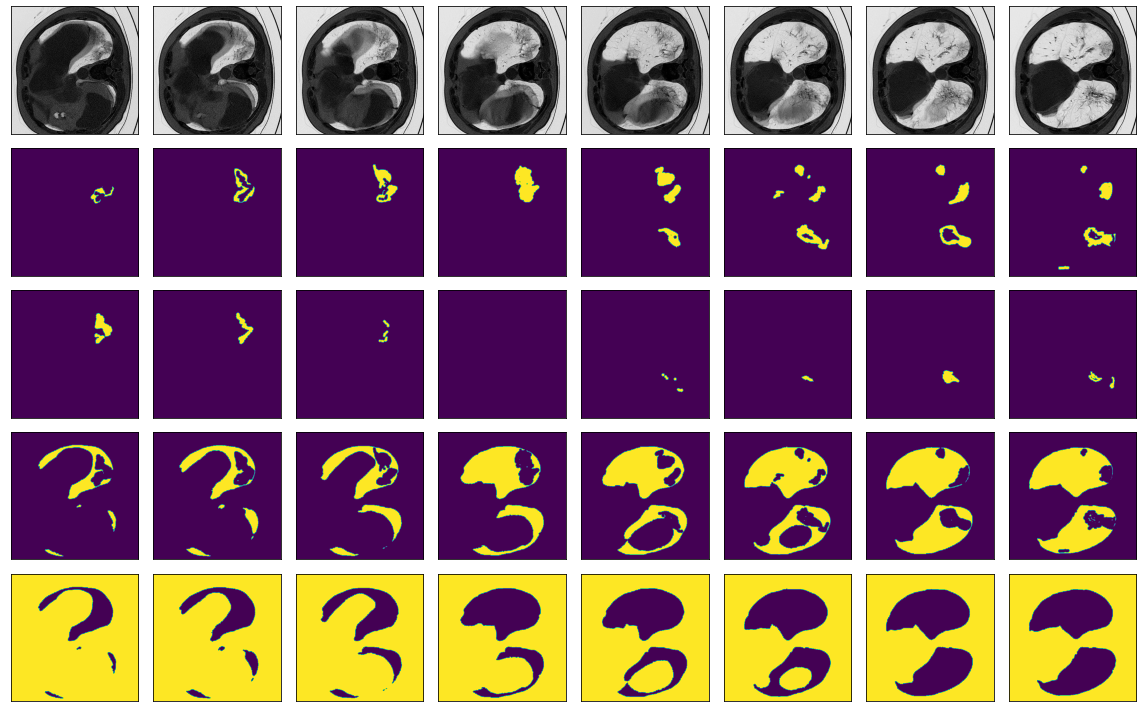

In [ ]:
visualize(images_radiopedia[12:], masks_radiopedia[12:])

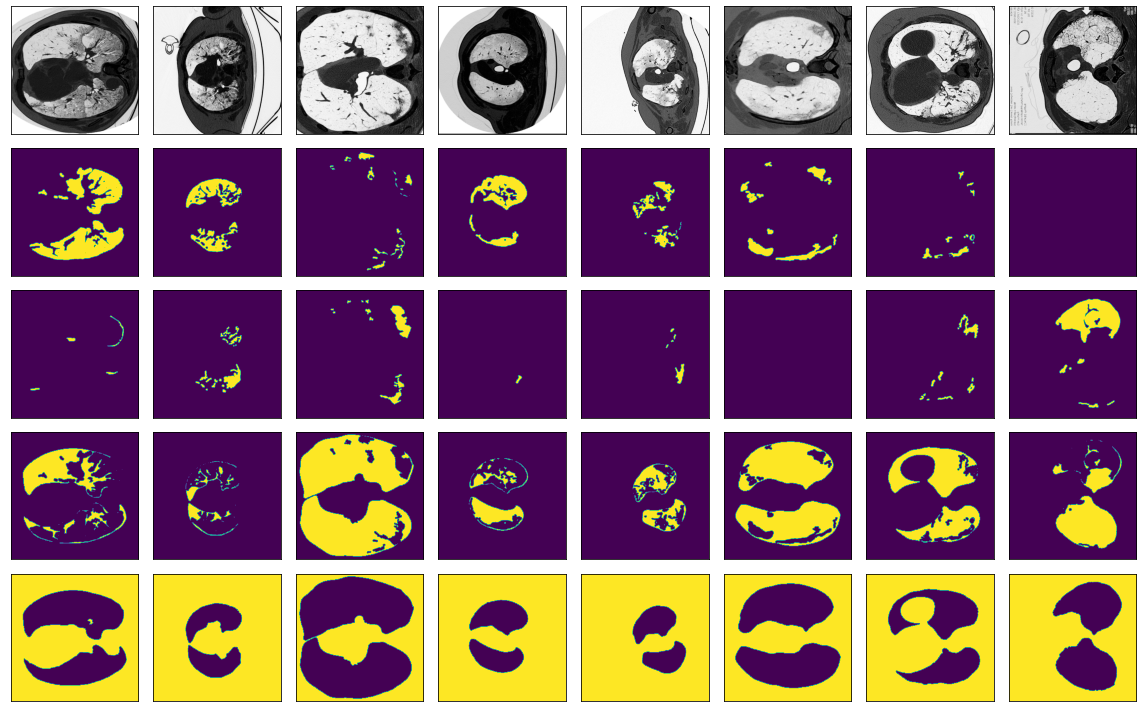

In [ ]:
visualize(images_medseg[8:], masks_medseg[8:])

In [ ]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)


mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


In [ ]:
print(images_radiopedia.shape)
print(images_medseg.shape)

(829, 512, 512, 1)
(100, 512, 512, 1)


In [ ]:
test_indexes, val_indexes, train_indexes = list(range(15)), list(range(16,30)), list(range(31, 100))
test_indexes_r, val_indexes_r, train_indexes_r = list(range(125)), list(range(126, 250)), list(range(251, 829))

train_m= images_medseg[train_indexes]
train_r=images_radiopedia[train_indexes_r]
train_m_masks = masks_medseg[train_indexes]
train_r_masks = masks_radiopedia[train_indexes_r]


val_m= images_medseg[val_indexes]
val_r=images_radiopedia[val_indexes_r]

val_m_masks = masks_medseg[val_indexes]
val_r_masks =masks_radiopedia[val_indexes_r]


test_m= images_medseg[test_indexes]
test_r=images_radiopedia[test_indexes_r]
test_m_masks = masks_medseg[test_indexes]
test_r_masks = masks_radiopedia[test_indexes_r]


print(train_m.shape, train_r.shape)
print(val_m.shape, val_r.shape)
print(test_m.shape, test_r.shape)

train_images = np.concatenate((train_m, train_r),axis=0)
val_images = np.concatenate((val_m, val_r),axis=0)
test_images = np.concatenate((test_m, test_r),axis=0)

train_masks = np.concatenate((train_m_masks, train_r_masks),axis=0)
val_masks = np.concatenate((val_m_masks, val_r_masks),axis=0)
test_masks = np.concatenate((test_m_masks, test_r_masks),axis=0)


# train_masks = np.concatenate(masks_radiopedia)
print(train_images.shape)


(69, 512, 512, 1) (578, 512, 512, 1)
(14, 512, 512, 1) (124, 512, 512, 1)
(15, 512, 512, 1) (125, 512, 512, 1)
(647, 512, 512, 1)


In [ ]:
batch_size = 16

Data generator and augmentations

In [ ]:
import tensorflow

import albumentations
import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 256

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
    # albumentations.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    # albumentations.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    # IAAAdditiveGaussianNoise(p=0.2)
])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [ ]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)
test_dataset = Dataset(test_images, test_masks, val_augs)


train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = Dataloder(test_dataset,batch_size=batch_size, shuffle=False)

check shape for errors

In [ ]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

  dataloader

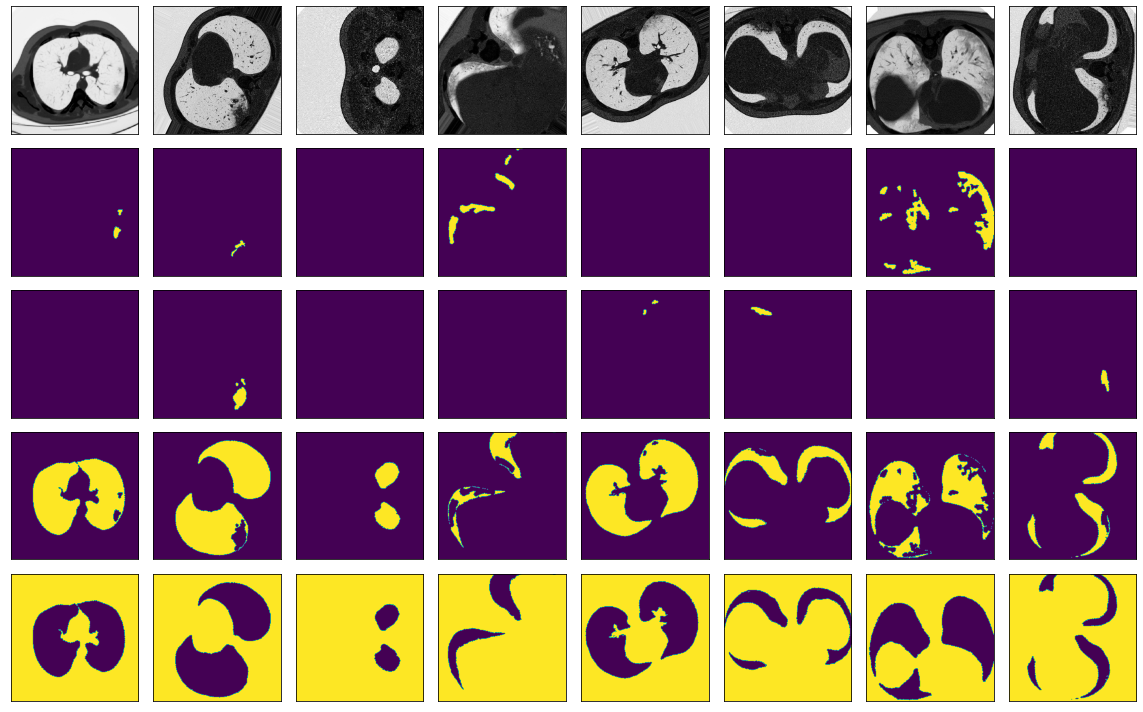

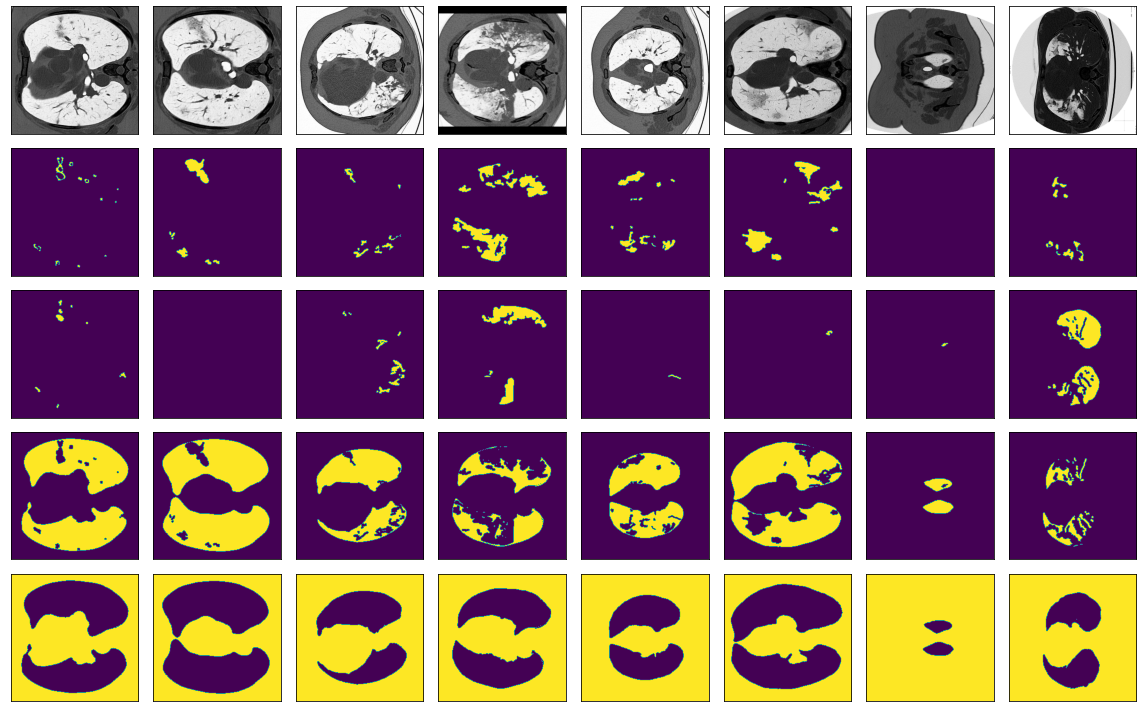

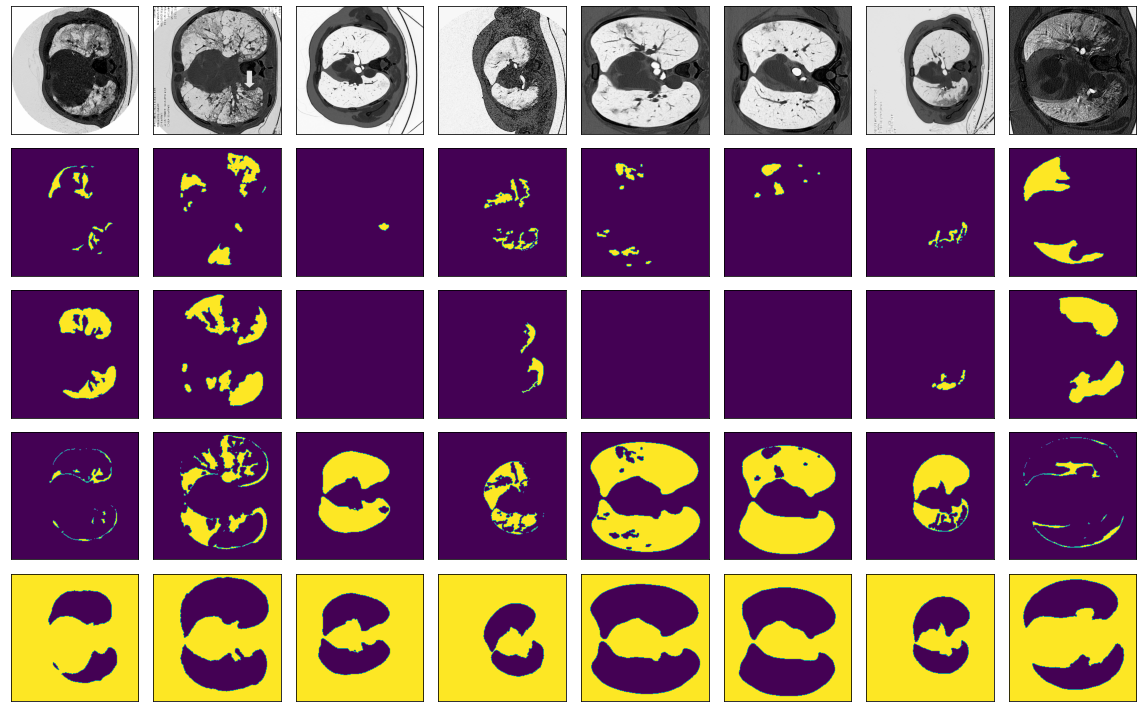

In [ ]:
visualize(*next(iter(train_dataloader)))
visualize(*next(iter(val_dataloader)))
visualize(*next(iter(test_dataloader)))

# FPN + EfficientNet B3

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='efficientnetb3',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

44122112/44107200 [==============================] - 0s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-EfficientnetB3.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-EfficientnetB3.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 134s 2s/step - loss: 0.0537 - iou_score: 0.4628 - f1-score: 0.4878 - val_loss: 0.0753 - val_iou_score: 0.6513 - val_f1-score: 0.6735 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 68s 2s/step - loss: 0.0179 - iou_score: 0.6194 - f1-score: 0.6857 - val_loss: 0.0388 - val_iou_score: 0.6772 - val_f1-score: 0.6976 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 68s 2s/step - loss: 0.0155 - iou_score: 0.7122 - f1-score: 0.7998 - val_loss: 0.0199 - val_iou_score: 0.7416 - val_f1-score: 0.7758 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 69s 2s/step - loss: 0.0151 - iou_score: 0.7322 - f1-score: 0.8191 - val_loss: 0.0228 - val_iou_score: 0.6576 - val_f1-score: 0.6821 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 68s 2s/step - loss: 0.0141 - iou_score: 0.7203 - f1-score: 0.8048 - val_loss: 0.0163 - val_iou_score: 0.6733 - val_f1-score: 0.7118 - lr: 0.0010
Epoch 6/1

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0079663
mean iou_score: 0.83237
mean f1-score: 0.89901


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0074781
mean iou_score: 0.83405
mean f1-score: 0.86491


Plots

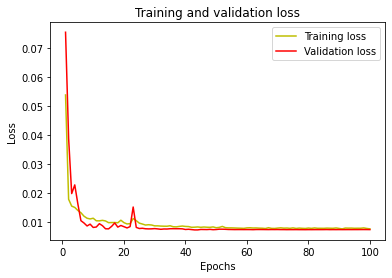

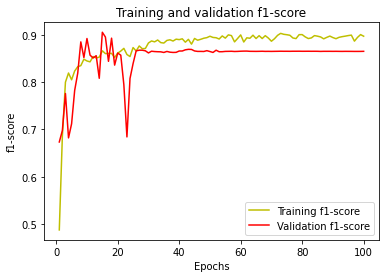

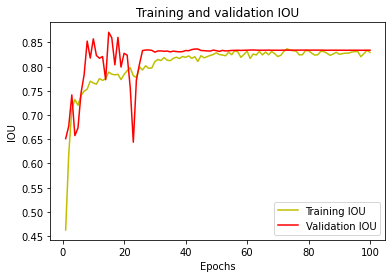

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.021446
mean iou_score: 0.64835
mean f1-score: 0.72348


In [ ]:
print(scores_test)

[0.021445613354444504, 0.6483458280563354, 0.723476231098175]


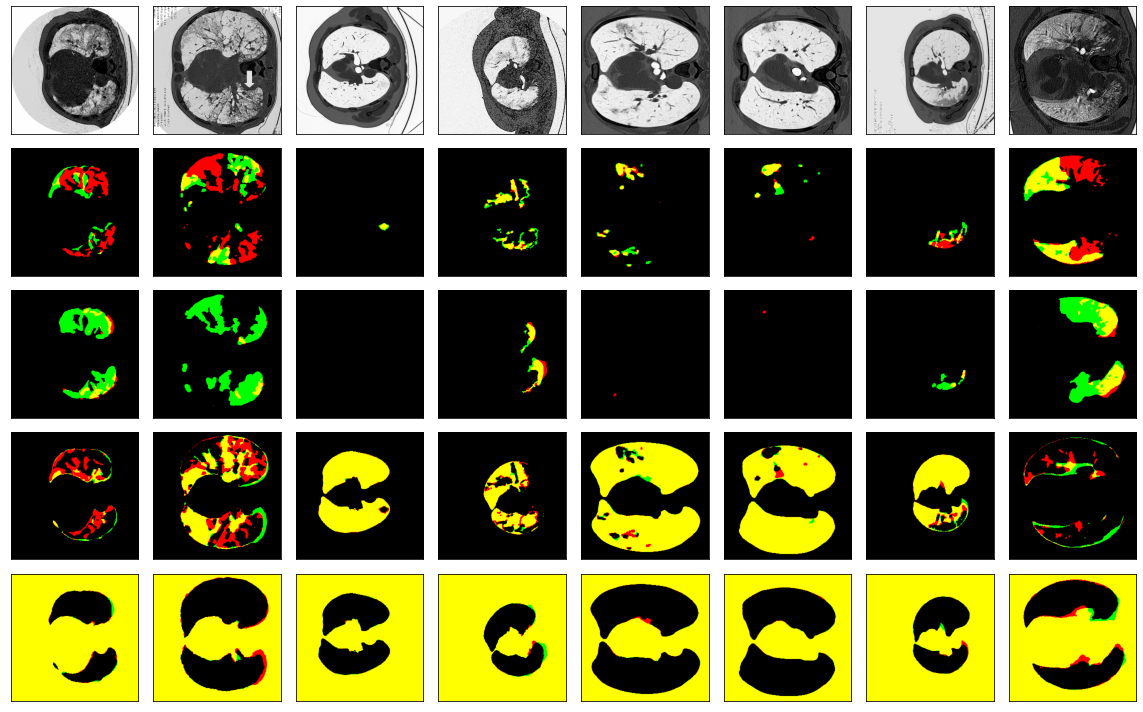

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# FPN + VGG19

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='vgg19',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

80150528/80134624 [==============================] - 1s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-vgg19.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-vgg19.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=100,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
40/40 [==============================] - 110s 2s/step - loss: 0.1122 - iou_score: 0.3855 - f1-score: 0.4280 - val_loss: 1.3624 - val_iou_score: 0.4598 - val_f1-score: 0.5209 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 60s 1s/step - loss: 0.0498 - iou_score: 0.4473 - f1-score: 0.4715 - val_loss: 0.1436 - val_iou_score: 0.5437 - val_f1-score: 0.5837 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 60s 1s/step - loss: 0.0461 - iou_score: 0.4504 - f1-score: 0.4732 - val_loss: 0.0867 - val_iou_score: 0.5850 - val_f1-score: 0.6251 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 60s 1s/step - loss: 0.0403 - iou_score: 0.4573 - f1-score: 0.4772 - val_loss: 0.0335 - val_iou_score: 0.6584 - val_f1-score: 0.6821 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 60s 1s/step - loss: 0.0386 - iou_score: 0.4597 - f1-score: 0.4785 - val_loss: 0.1136 - val_iou_score: 0.5659 - val_f1-score: 0.5782 - lr: 0.0010
Epoch 6/1

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.012435
mean iou_score: 0.74091
mean f1-score: 0.82466


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.010029
mean iou_score: 0.79114
mean f1-score: 0.83057


Plots

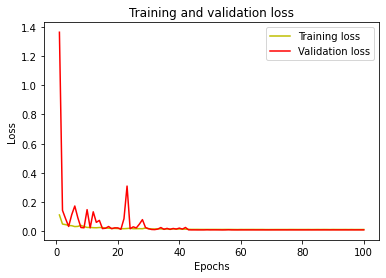

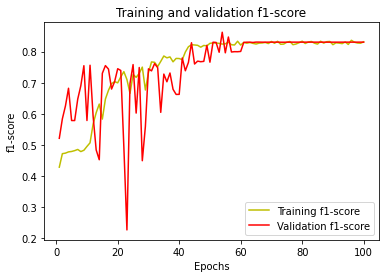

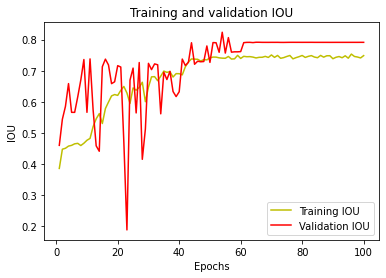

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Testing

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.023033
mean iou_score: 0.58259
mean f1-score: 0.65396


In [ ]:
print(scores_test)

[0.02303283102810383, 0.5825895071029663, 0.6539602279663086]


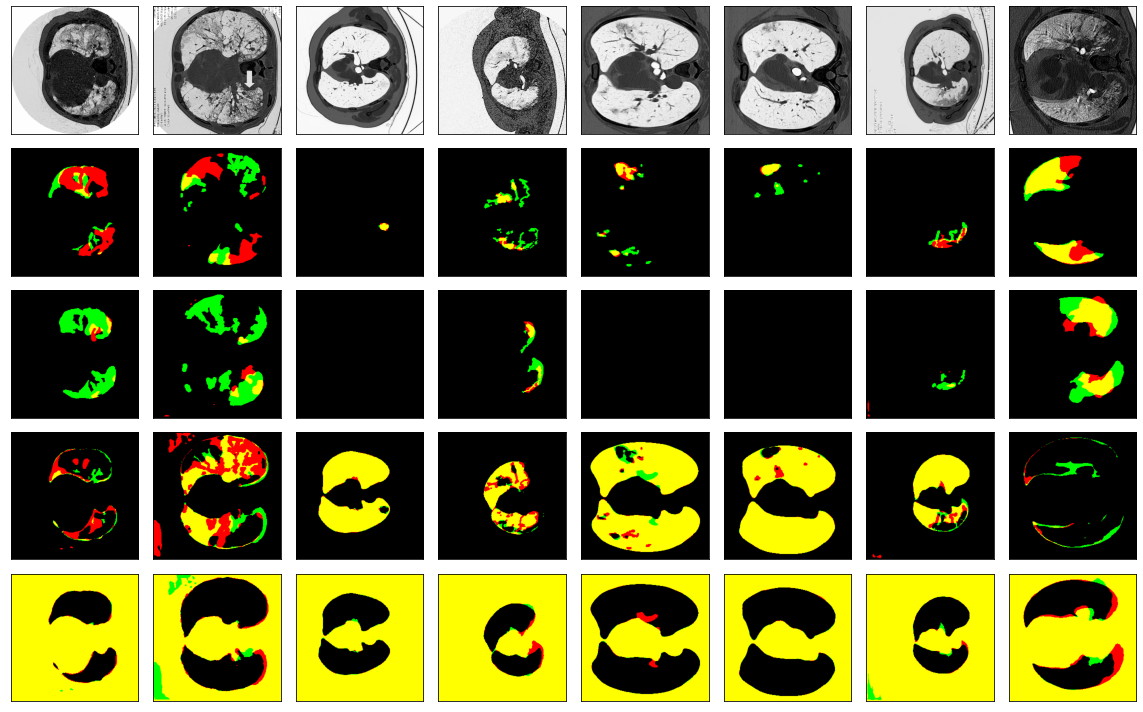

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# FPN + Inceptionresnetv2

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='inceptionresnetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

219070464/219055592 [==============================] - 2s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-inceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-inceptionresnetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0080996
mean iou_score: 0.82729
mean f1-score: 0.89516


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0074761
mean iou_score: 0.84619
mean f1-score: 0.87923


Plots

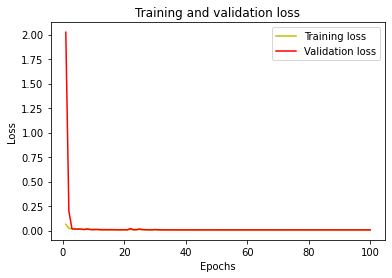

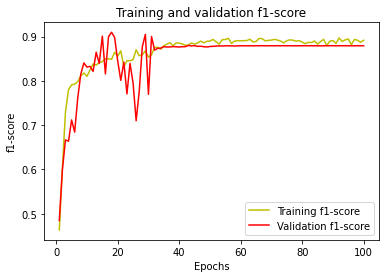

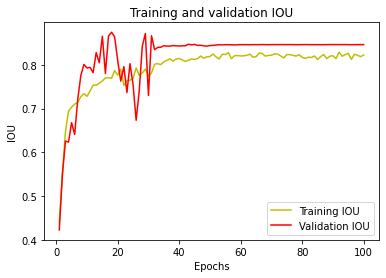

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-EfficientnetB3.h5')

model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.019756
mean iou_score: 0.65002
mean f1-score: 0.72378


In [ ]:
print(scores_test)

[0.01975647173821926, 0.6500208973884583, 0.7237775921821594]


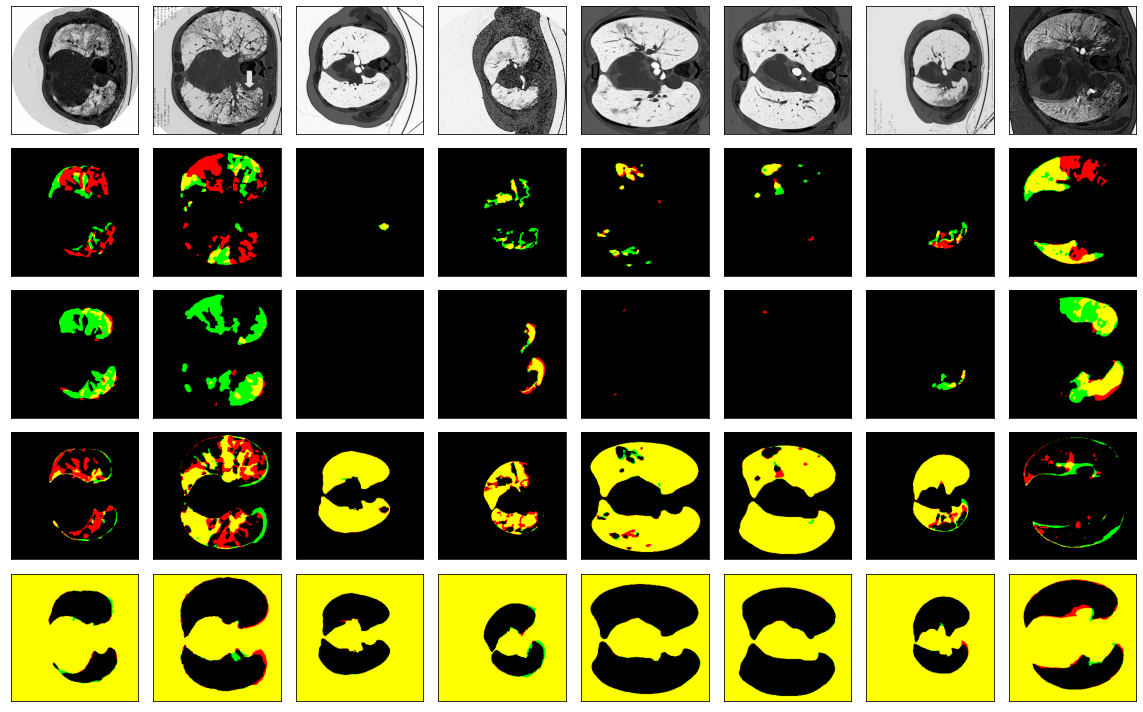

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# FPN + Densenet 121

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='densenet121',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

29097984/29084464 [==============================] - 1s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-densenet121.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-densenet121.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 78s 1s/step - loss: 0.0617 - iou_score: 0.4481 - f1-score: 0.4767 - val_loss: 0.1334 - val_iou_score: 0.5938 - val_f1-score: 0.6360 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 55s 1s/step - loss: 0.0237 - iou_score: 0.5071 - f1-score: 0.5391 - val_loss: 0.0903 - val_iou_score: 0.7024 - val_f1-score: 0.7370 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 56s 1s/step - loss: 0.0238 - iou_score: 0.5931 - f1-score: 0.6667 - val_loss: 0.1859 - val_iou_score: 0.5042 - val_f1-score: 0.5360 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 55s 1s/step - loss: 0.0211 - iou_score: 0.6245 - f1-score: 0.7043 - val_loss: 0.0176 - val_iou_score: 0.5482 - val_f1-score: 0.5907 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 55s 1s/step - loss: 0.0173 - iou_score: 0.6796 - f1-score: 0.7671 - val_loss: 0.0260 - val_iou_score: 0.6716 - val_f1-score: 0.7029 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0087779
mean iou_score: 0.81032
mean f1-score: 0.87928


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0068993
mean iou_score: 0.79373
mean f1-score: 0.82519


Plots

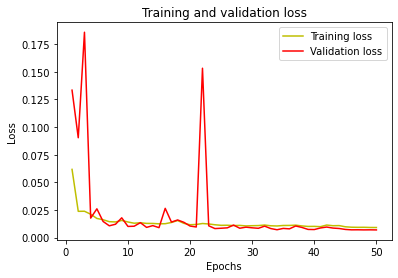

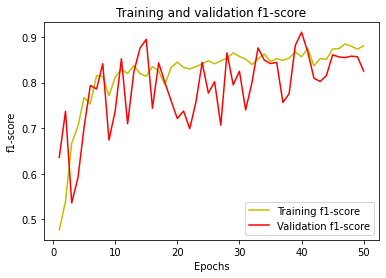

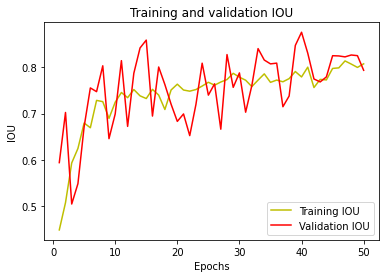

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-densenet121.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.017999
mean iou_score: 0.66485
mean f1-score: 0.73869


In [ ]:
print(scores_test)

[0.017998870462179184, 0.664845883846283, 0.7386888861656189]


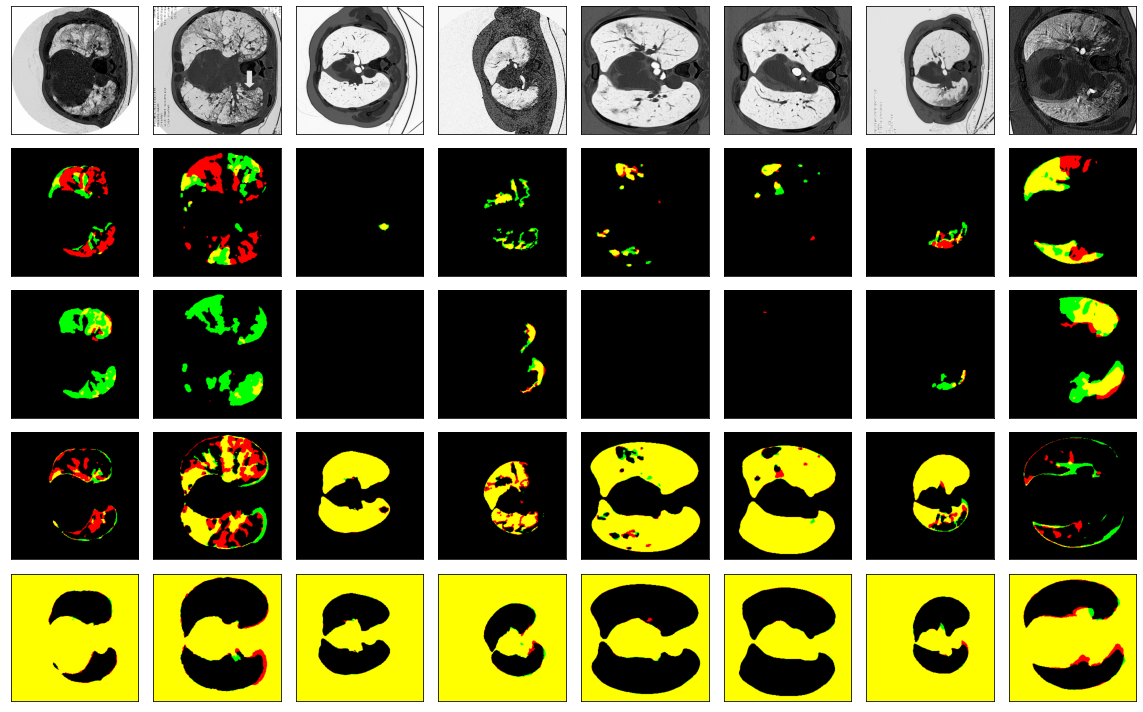

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# FPN + Mobilenet V2

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='mobilenetv2',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9420800/9406464 [==============================] - 0s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-mobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-mobilenetv2.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 56s 1s/step - loss: 0.0589 - iou_score: 0.4565 - f1-score: 0.4841 - val_loss: 0.7531 - val_iou_score: 0.5001 - val_f1-score: 0.5525 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 46s 1s/step - loss: 0.0199 - iou_score: 0.5706 - f1-score: 0.6313 - val_loss: 0.3720 - val_iou_score: 0.5387 - val_f1-score: 0.5860 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 44s 1s/step - loss: 0.0167 - iou_score: 0.6698 - f1-score: 0.7558 - val_loss: 0.4019 - val_iou_score: 0.5322 - val_f1-score: 0.5806 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 44s 1s/step - loss: 0.0162 - iou_score: 0.6855 - f1-score: 0.7719 - val_loss: 0.1443 - val_iou_score: 0.5354 - val_f1-score: 0.5744 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 44s 1s/step - loss: 0.0149 - iou_score: 0.7057 - f1-score: 0.7939 - val_loss: 0.0541 - val_iou_score: 0.7047 - val_f1-score: 0.7308 - lr: 0.0010
Epoch 6/50
40/4

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.010751
mean iou_score: 0.76409
mean f1-score: 0.84468


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0097894
mean iou_score: 0.77891
mean f1-score: 0.81589


Plots

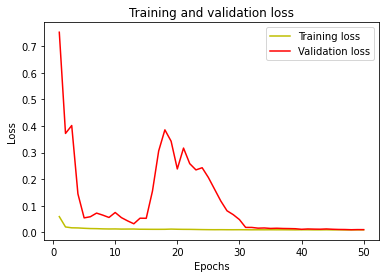

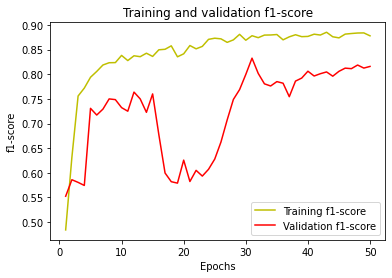

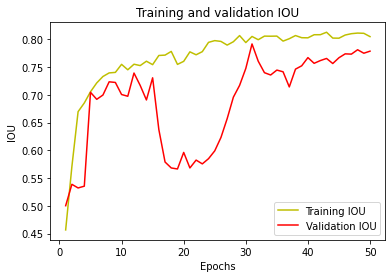

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-densenet121.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.029284
mean iou_score: 0.60282
mean f1-score: 0.67358


In [ ]:
print(scores_test)

[0.029284454882144928, 0.6028196811676025, 0.6735820174217224]


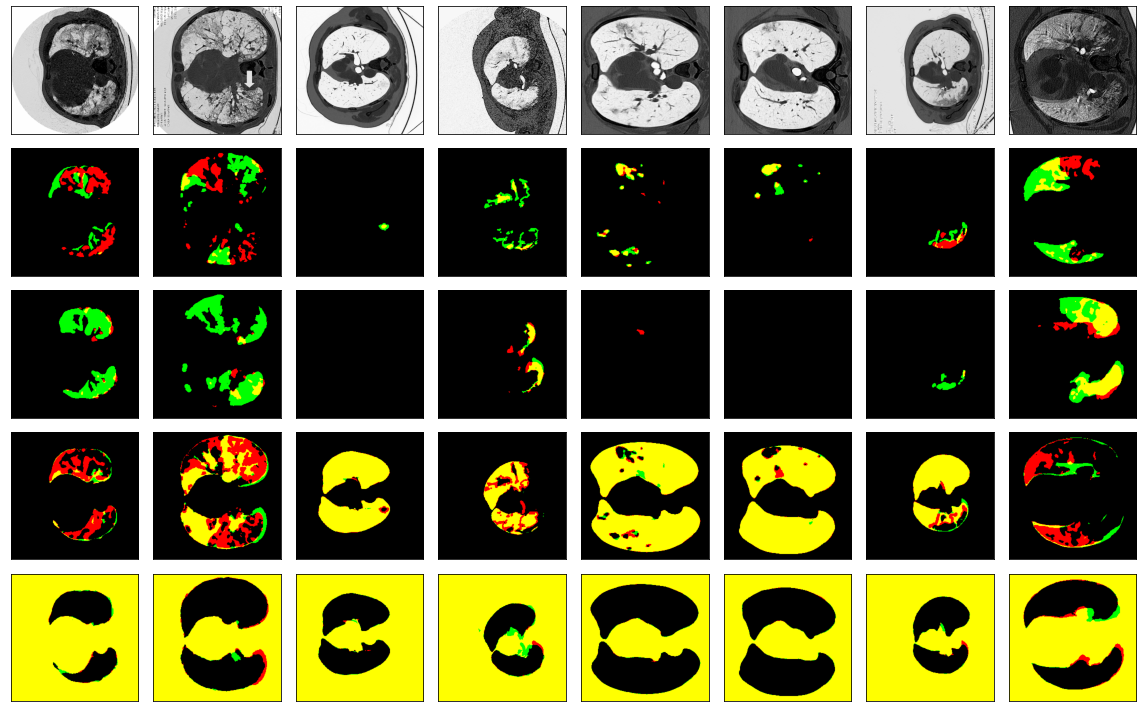

In [ ]:
input = test_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN

# FPN + Seresnet101

Model define

In [ ]:
from segmentation_models import FPN
import segmentation_models as sm



sm.set_framework('tf.keras')

sm.framework()

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = FPN(backbone_name='seresnet101',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')


model = Sequential([Input(shape=(TARGET_SIZE, TARGET_SIZE, 1)),
                    Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                    base_model])

190676992/190663368 [==============================] - 2s 0us/step


Combo Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
from tensorflow import keras

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

# # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.CategoricalFocalLoss() #if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

# metrics = [fscore_glass_and_consolidation,fscore_glass,fscore_consolidation,fscore_lungs_other,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# # compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

callbacks

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FPN/Models/K-FPN-seresnet101.h5', save_weights_only=True, save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/FPN/CSV/K-FPN-seresnet101.csv', separator=",", append=True)
]

In [ ]:
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=50,
    validation_data=val_dataloader,
    validation_steps=len(val_dataloader),
    callbacks=[callbacks],
    workers=4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
40/40 [==============================] - 142s 2s/step - loss: 0.0443 - iou_score: 0.4771 - f1-score: 0.5054 - val_loss: 2.1446 - val_iou_score: 0.2204 - val_f1-score: 0.2700 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 77s 2s/step - loss: 0.0203 - iou_score: 0.5856 - f1-score: 0.6490 - val_loss: 2.2245 - val_iou_score: 0.3150 - val_f1-score: 0.3739 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 74s 2s/step - loss: 0.0234 - iou_score: 0.6057 - f1-score: 0.6804 - val_loss: 0.2114 - val_iou_score: 0.4817 - val_f1-score: 0.5279 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 74s 2s/step - loss: 0.0159 - iou_score: 0.6887 - f1-score: 0.7745 - val_loss: 0.0993 - val_iou_score: 0.6014 - val_f1-score: 0.6383 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 74s 2s/step - loss: 0.0144 - iou_score: 0.7057 - f1-score: 0.7894 - val_loss: 0.0518 - val_iou_score: 0.6288 - val_f1-score: 0.6793 - lr: 0.0010
Epoch 6/50
40/

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.008705
mean iou_score: 0.8141
mean f1-score: 0.88493


In [ ]:
scores = model.evaluate_generator(val_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.0070675
mean iou_score: 0.85464
mean f1-score: 0.88708


Plots

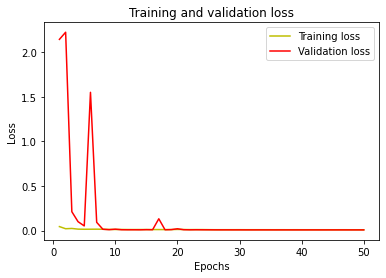

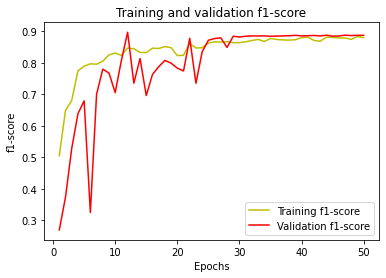

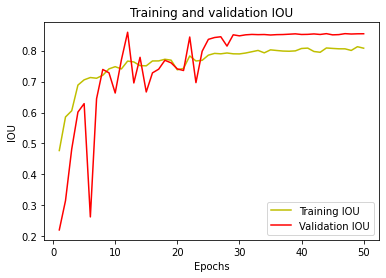

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




acc = history.history['f1-score']
val_acc = history.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()




acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Kaggle MnC/Unet/Models/K-Unet-densenet121.h5')

# model.compile(optim, total_loss, metrics)

In [ ]:
scores_test = model.evaluate_generator(test_dataloader)


print("Loss: {:.5}".format(scores_test[0]))
for metric, value in zip(metrics, scores_test[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss: 0.020189
mean iou_score: 0.65429
mean f1-score: 0.72639


In [ ]:
print(scores_test)

[0.020188646391034126, 0.6542911529541016, 0.7263919115066528]


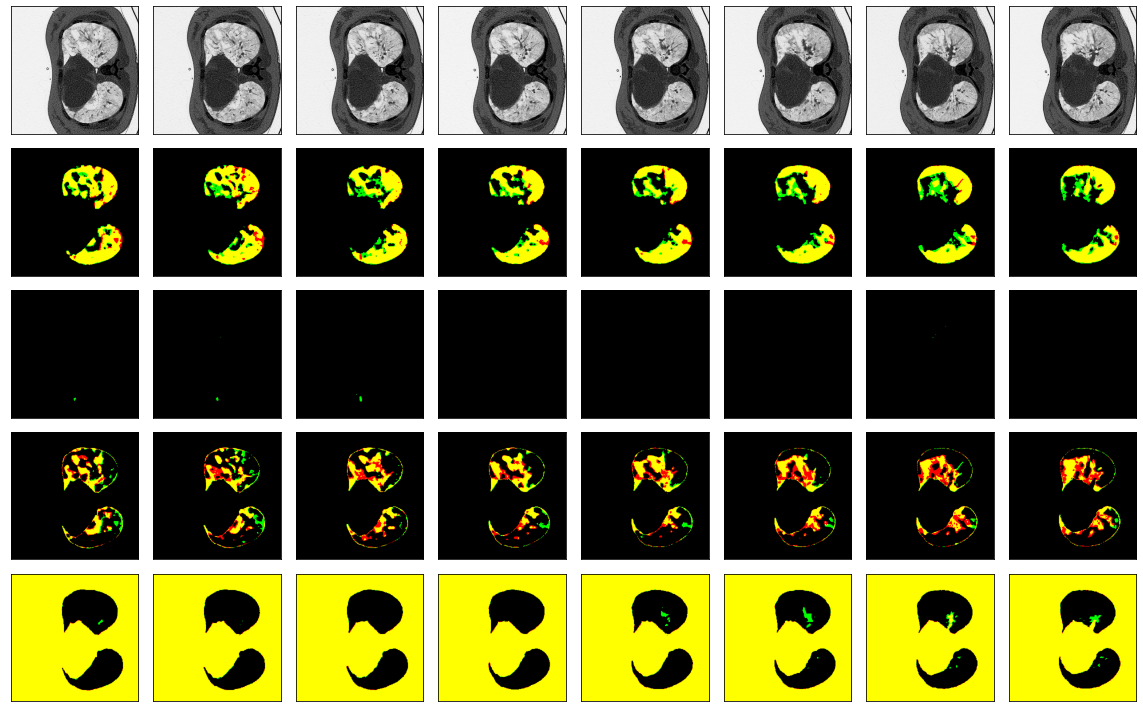

In [ ]:
input = test_dataloader[7]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

# yellow is TP, red is FP, green is FN